In [1]:
import pandas as pd
import numpy as np
import free_throw_helpers as fth
import warnings

In [2]:
every_free_throw = pd.read_csv('data/free_throws.csv')

In [3]:
basketball_ref_url_16 = 'https://www.basketball-reference.com/leagues/NBA_2016_totals.html'
basketball_ref_url_15 = 'https://www.basketball-reference.com/leagues/NBA_2015_totals.html'
basketball_ref_url_14 = 'https://www.basketball-reference.com/leagues/NBA_2014_totals.html'

In [4]:
# Reads in seasons from 2013-2016
basketball_ref_stats_16 = pd.read_html(basketball_ref_url_16)
basketball_ref_stats_15 = pd.read_html(basketball_ref_url_15)
basketball_ref_stats_14 = pd.read_html(basketball_ref_url_14)

In [5]:
basketball_ref_stats_16_df = basketball_ref_stats_16[0]
basketball_ref_stats_15_df = basketball_ref_stats_15[0]
basketball_ref_stats_14_df = basketball_ref_stats_14[0]

In [6]:
# If a player is traded midseason they have a row for each team and then a Total row. We only want Total row.
def drop_extra_rows_for_traded_player(df):
    player = ''
    for index,row in df.iterrows():
        if row['Tm'] == 'TOT':
            player = row['Player']
        elif player == row['Player']:
            row['Player'] = np.nan
    df = df[pd.notnull(df['Player'])]
    return df

In [7]:
basketball_ref_stats_14_df = drop_extra_rows_for_traded_player(basketball_ref_stats_14_df)
basketball_ref_stats_15_df = drop_extra_rows_for_traded_player(basketball_ref_stats_15_df)
basketball_ref_stats_16_df = drop_extra_rows_for_traded_player(basketball_ref_stats_16_df)

In [8]:
# Puts all 3 seasons freethrow numbers into fourth_quarter_ot_freethrows
seasons = ['2013 - 2014', '2014 - 2015', '2015 - 2016']
s = every_free_throw.season.isin(seasons)
fourth_quarter_ot_free_throws = every_free_throw[s]

In [9]:
# gets only 4th quarter/ OT free throws
fourth_quarter_ot_free_throws = fourth_quarter_ot_free_throws[fourth_quarter_ot_free_throws['period'] >= 4]
fourth_quarter_ot_free_throws['score_diff'] = fourth_quarter_ot_free_throws['score'].apply(fth.score_difference)
time_seconds = fourth_quarter_ot_free_throws['time'].apply(fth.time_into_seconds)
fourth_quarter_ot_free_throws['time_seconds'] = time_seconds
clutch_free_throws = fourth_quarter_ot_free_throws[(fourth_quarter_ot_free_throws['time_seconds'] <= 120) &
                                                 (fourth_quarter_ot_free_throws['score_diff'] <= 5)]
warnings.filterwarnings('ignore')
clutch_free_throws['player'] = clutch_free_throws['player'].apply(fth.fix_player_syntax)

In [10]:
# clutch free throws made
clutch_ft_by_player = clutch_free_throws.groupby('player').shot_made.sum()
clutch_ft_by_player = clutch_ft_by_player.to_frame()
clutch_ft_by_player.columns = ['clutch_fts_made']
clutch_ft_by_player['clutch_fts_attempted'] = clutch_free_throws.groupby('player').shot_made.count()
clutch_ft_by_player['clutch_ft_decimal_percent'] = (clutch_ft_by_player['clutch_fts_made'] / clutch_ft_by_player['clutch_fts_attempted'])
clutch_ft_by_player['clutch_fts_attempted'].describe()

count    397.000000
mean      19.430730
std       23.982809
min        1.000000
25%        4.000000
50%       11.000000
75%       25.000000
max      139.000000
Name: clutch_fts_attempted, dtype: float64

In [11]:
combined_14_15_seasons_stats = basketball_ref_stats_14_df.merge(basketball_ref_stats_15_df, on = 'Player', how='outer')
all_season_combined = combined_14_15_seasons_stats.merge(basketball_ref_stats_16_df, on ='Player', how='outer')
# drop header rows
all_season_combined = all_season_combined.drop(all_season_combined[all_season_combined['FTA_x'] == 'FTA'].index, )
all_season_combined = all_season_combined.fillna(0)

In [12]:
# make into integers instead of strings
all_season_combined['FTA_x'] = all_season_combined['FTA_x'].apply(lambda x: int(x))
all_season_combined['FTA_y'] = all_season_combined['FTA_y'].apply(lambda x: int(x))
all_season_combined['FTA'] = all_season_combined['FTA'].apply(lambda x: int(x))
# make into intgeres instead of strings
all_season_combined['FT_x'] = all_season_combined['FT_x'].apply(lambda x: int(x))
all_season_combined['FT_y'] = all_season_combined['FT_y'].apply(lambda x: int(x))
all_season_combined['FT'] = all_season_combined['FT'].apply(lambda x: int(x))

In [13]:
# make combined ft percentage for all 3 seasons
all_season_combined['total_ftm'] = all_season_combined['FT_x'] + all_season_combined['FT_y'] + all_season_combined['FT'] 
all_season_combined['total_fta'] = (all_season_combined['FTA_x'] + all_season_combined['FTA_y'] + all_season_combined['FTA'])
all_season_combined['total_ft%'] = (all_season_combined['total_ftm']) / (all_season_combined['total_fta'])

In [14]:
# normalize player name syntax for all seasons players
all_season_combined['Player'] = all_season_combined['Player'].apply(fth.fix_player_syntax)
clutch_ft_by_player = clutch_ft_by_player.reset_index()
# then merge clutch free throws onto that 3 season data frame 
clutch_and_total_combined = all_season_combined.merge(clutch_ft_by_player, left_on='Player', right_on='player')
# data frame with only clutch ft attempts > 75th percentile in attempts
sorted_clutch_and_total = clutch_and_total_combined[clutch_and_total_combined['clutch_fts_attempted'] >= 25]

In [15]:
# biggest changes positive or negative
warnings.filterwarnings('ignore')
sorted_clutch_and_total['ft_difference_in_clutch'] = sorted_clutch_and_total['clutch_ft_decimal_percent'] - \
                                                         sorted_clutch_and_total['total_ft%']

In [16]:
# biggest improvement in free throws
biggest_improvement_5 = sorted_clutch_and_total.sort_values('ft_difference_in_clutch', ascending=False).head(5)
# biggest regression in free throws
biggest_regression_5 = sorted_clutch_and_total.sort_values('ft_difference_in_clutch').head(5)
# best overall clutch percentage
best_overall_5 = sorted_clutch_and_total.sort_values('clutch_ft_decimal_percent', ascending = False).head(5)
# worst overall clutch percentage
worst_overall_5 = sorted_clutch_and_total.sort_values('clutch_ft_decimal_percent').head(5)

In [17]:
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.ticker as mtick
%matplotlib inline
plt.rcParams.update({'font.size': 8, 'font.weight': 'bold'})

In [18]:
sorted_clutch_and_total['ft_difference_in_clutch'].mean()
# only a slight negative difference overall

-0.016719965781830232

In [19]:
# Creates chart showing comparison between overall free throws and in the clutch free throws.
# Limits to given list of players
def create_comparison_graph(df_original, chart_title, include_diff = False):
    df = df_original.copy()
    df['ft_difference_in_clutch'] = df['ft_difference_in_clutch'] * 100
    df['total_ft%'] = df['total_ft%'] * 100
    df['clutch_ft_decimal_percent'] = df['clutch_ft_decimal_percent'] * 100
    if include_diff:
        y_columns = ['ft_difference_in_clutch','total_ft%','clutch_ft_decimal_percent']
        y_labels = ['FT % Difference in Clutch', 'Total FT %', 'Clutch FT %']
    else: 
        y_columns = ['total_ft%','clutch_ft_decimal_percent']
        y_labels = ['Total FT %', 'Clutch FT %']
    y_lim_min = min((df['ft_difference_in_clutch'].min() * 1.1), 0)
    bar = df.plot(x = 'Player', y= y_columns, kind = 'bar',title = chart_title, ylim = (y_lim_min,110), alpha = 0.6)
    bar.set_ylabel('Free Throw %')
    bar.yaxis.set_major_formatter(mtick.PercentFormatter())
    for i in bar.patches:
        bar.annotate(str(round(i.get_height(), 1))+'%', xy=((i.get_x() - .035), (i.get_height() + 0.01)))
    bar.legend(loc='upper center', bbox_to_anchor=(1.2, 1.0),
          fancybox=True, labels= y_labels)
    return bar

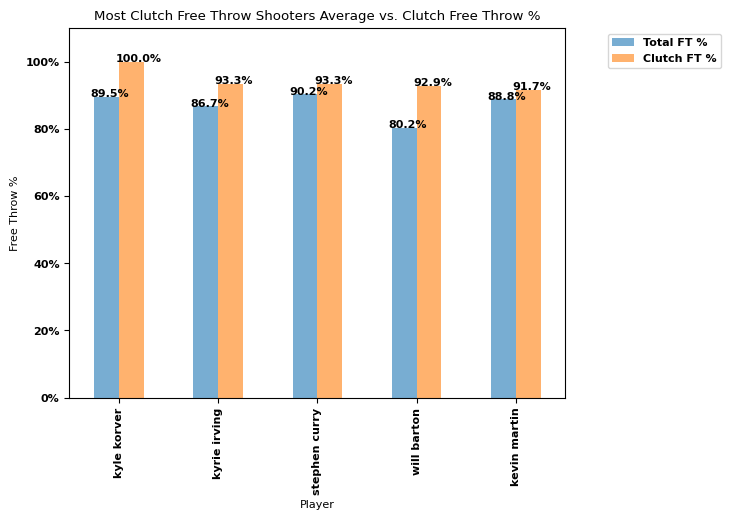

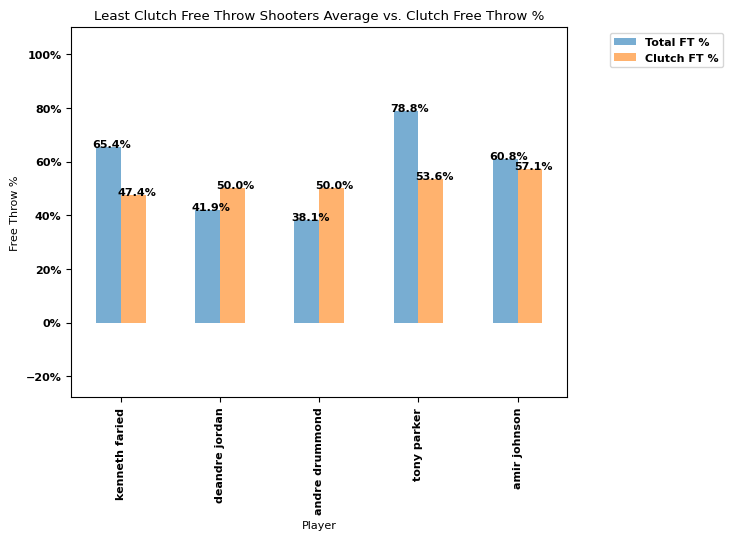

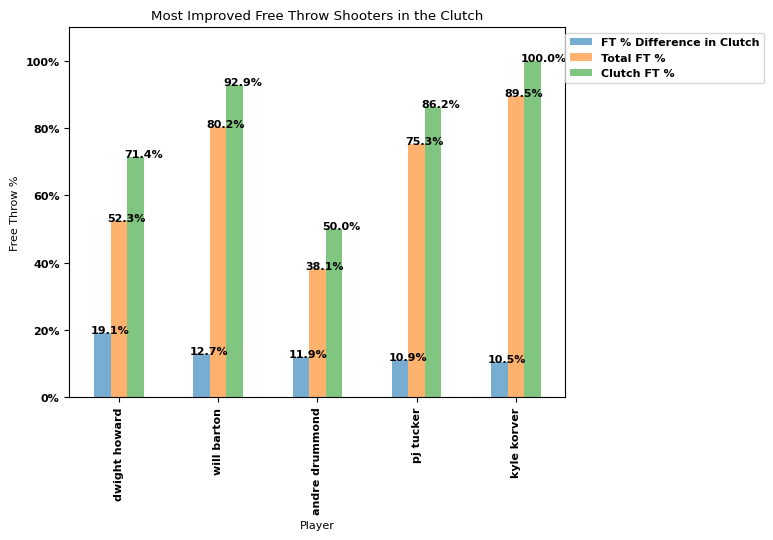

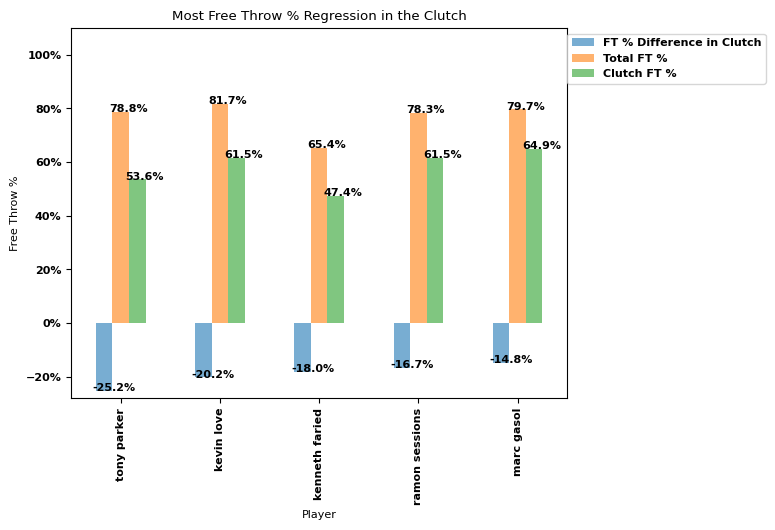

In [20]:
best_5_chart = create_comparison_graph(best_overall_5, 'Most Clutch Free Throw Shooters Average vs. Clutch Free Throw %')
worst_5_chart = create_comparison_graph(worst_overall_5, 'Least Clutch Free Throw Shooters Average vs. Clutch Free Throw %')
improved_5_chart = create_comparison_graph(biggest_improvement_5, 'Most Improved Free Throw Shooters in the Clutch', include_diff=True)
regressed_5_chart = create_comparison_graph(biggest_regression_5, 'Most Free Throw % Regression in the Clutch', include_diff=True)

In [21]:
# Remove the overlapping free throws from overall in order to properly test significance
clutch_and_total_combined['total_ftm_w_out_clutch'] = clutch_and_total_combined['total_ftm'] - clutch_and_total_combined['clutch_fts_made']
clutch_and_total_combined['total_fta_w_out_clutch'] = clutch_and_total_combined['total_fta'] - clutch_and_total_combined['clutch_fts_attempted']
clutch_and_total_combined['total_ft%_w_out_clutch'] = clutch_and_total_combined['total_ftm_w_out_clutch'] / clutch_and_total_combined['total_fta_w_out_clutch']

In [22]:
from scipy.stats import ttest_ind
ttest_ind(clutch_and_total_combined['clutch_ft_decimal_percent'], clutch_and_total_combined['total_ft%_w_out_clutch'])

TtestResult(statistic=-1.7535537313584806, pvalue=0.07992781764130379, df=728.0)

In [23]:
#add in more seasons will have to look for more free throw data
# use all free throw data from CSV. Just can't break down versus average
every_free_throw_by_player = pd.DataFrame(columns=['player', 'ftm','fta','ft_percent', \
                                                   'clutch_ftm', 'clutch_fta', 'clutch_ft_percent'])

every_free_throw_by_player['player'] = sorted(every_free_throw['player'].unique())

In [24]:
# gets total free throw numbers during span
every_free_throw_by_player['ftm'] = list(every_free_throw.groupby('player').sum().shot_made)
every_free_throw_by_player['fta'] = list(every_free_throw.groupby('player').count().shot_made)
every_free_throw_by_player['ft_percent'] = every_free_throw_by_player['ftm'] / every_free_throw_by_player['fta']

In [25]:
# filter to only clutch free throws
clutch_fts = every_free_throw[every_free_throw['period'] >= 4]
clutch_fts['time_secs'] = clutch_fts['time'].apply(fth.time_into_seconds)
clutch_fts['score_diff'] = clutch_fts['score'].apply(fth.score_difference)
clutch_fts = clutch_fts[(clutch_fts['time_secs'] <= 120) &
                                              (clutch_fts['score_diff'] <= 5)]

# Some players didn't make any clutch players need to merge results of fta and ftm on player into every_player

#  clutch_fts.groupby('player').sum().shot_made
# clutch_fts.groupby('player').count().shot_made

# every_free_throw_by_player['clutch_ft_percent'] = every_free_throw_by_player['clutch_ftm'] / every_free_throw_by_player['clutch_fta']


In [26]:
## TO DO: USE DIFFERENT T TESTS (LOOK AT SPORTS ANALYTICS EXAMPLE)
## UPDATE GRAPHS TO BE PRETTIER 
## RENAME FT COLUMNS SO DON'T HAVE TO DEAL WITH FT_X FT_Y etc. LIMIT TO ONLY NEEDED COLUMNS
## REMOVE CLUTCH FREE THROWS FROM OVERALL NUMBERS
## ADD IN FUNCTION TO PLOT A PLAYER COMPARISONS BY NAME IN THE CLUTCH
## ADD A FUNCTION TO TEST IF OPTIONALLY THE INDIVIDUAL OR TOTALITY PLAYER PERFOMES SIGNIFICANTLY DIFFERENT IN THE CLUTCH

## UPLOAD THIS INTO GITHUB